<a href="https://colab.research.google.com/github/ssroka/ML_for_emissions_monitoring/blob/main/syntheticEmissionsData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
# NN
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# the usual suspects
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Define Gaussian

In [16]:
# create a NxN matrix of values corresponding to a 2D Gaussian
# z: the number of +/- standard deviations
# sigma: standard deviation
# mu: mean=0
def gaussian2D(N=10, z=1.0, sigma=1.0):
  # mean = 0
  mu_x = 0
  mu_y = 0
  # create grid from -z*sigma to + z*sigma
  x, y = np.meshgrid(np.linspace(-z*sigma,z*sigma,N),
                     np.linspace(-z*sigma,z*sigma,N))
  G = np.exp(-((x-mu_x)**2/(2*sigma**2)+(y-mu_y)**2/(2*sigma**2)))
  return G

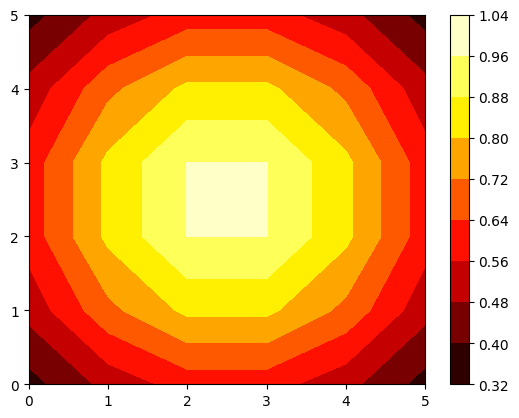

In [ ]:
N = 6
z = 1
sigma = 1
G = gaussian2D(N,z,sigma)
plt.contourf(G,cmap='hot')
plt.colorbar()
plt.show()

#create coordinate system

In [109]:
# parameters
x_lim = [0,50]
x_n = 51

y_lim = [0,30]
y_n = 31

In [154]:
x, y = np.meshgrid(np.linspace(x_lim[0], x_lim[1], x_n), np.linspace(y_lim[0], y_lim[1], y_n))

# create list of peaks

In [276]:
N_sources = 20 # number of emitters

In [229]:
r = np.random.uniform(5,15,N_sources).astype(int) # footprint of the 2D gaussian, will be an rxr array

In [230]:
sigma = np.random.uniform(0.5,5,N_sources) # create the variances

In [231]:
h = np.random.uniform(0,10,N_sources) # scale the peak of the source

In [275]:
N_samples = 1000*y_n # samples to be split into test and train

In [296]:
data = np.zeros((N_samples,x_n,1))
labels = np.zeros((N_samples,x_n,))
for j in range(int(N_samples/y_n)):
  mu_x = []
  mu_y = []

  sample = np.zeros_like(x)
  sample_label = np.zeros_like(x)

  for i in range(N_sources):
    g = gaussian2D(r[i],2.0,sigma[i])
    # set place in data matrix without going over an edge
    mu_x.append(int(np.random.uniform(x_lim[0]+r[i]/2, x_lim[1]-r[i]/2)))
    mu_y.append(int(np.random.uniform(y_lim[0]+r[i]/2, y_lim[1]-r[i]/2)))
    # coordinates to add
    row_start = mu_y[i]-int(r[i]/2)
    row_end = row_start + r[i]
    col_start = mu_x[i]-int(r[i]/2)
    col_end = col_start + r[i]
    # add to data matrix
    sample[row_start:row_end,col_start:col_end] += g
    # mark the centers
    sample_label[mu_y[i]-1:mu_y[i]+2,mu_x[i]-1:mu_x[i]+2] = 1

  data[j*y_n:(j+1)*y_n] = sample.reshape(y_n,x_n,1)
  labels[j*y_n:(j+1)*y_n] = sample_label.reshape(y_n,x_n,)

# plot data

1D plot

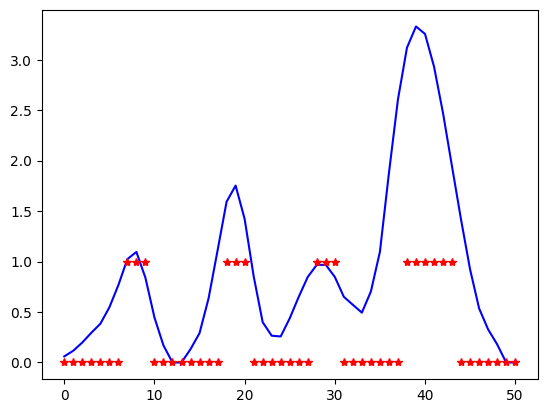

In [300]:
plot_num = 300

plt.plot(data[plot_num],color='blue')
plt.plot(labels[plot_num],'r*')
plt.show()

2D plot

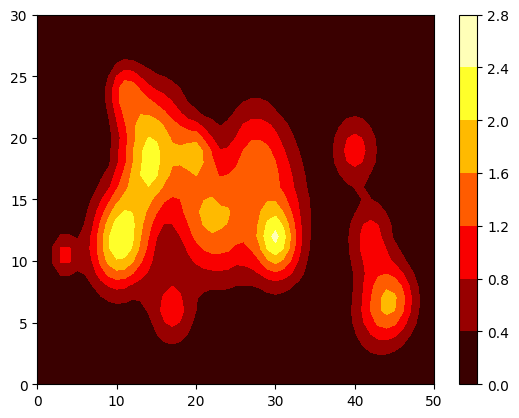

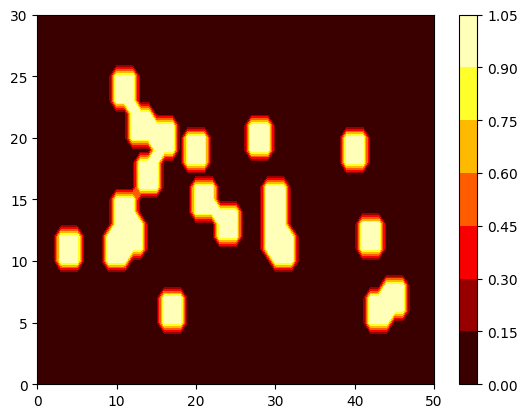

In [247]:
plot_num = 180

plt.contourf(data[plot_num].reshape(y_n,x_n),cmap='hot')
plt.colorbar()
plt.show()

plt.contourf(labels[plot_num].reshape(y_n,x_n),cmap='hot')
plt.colorbar()
plt.show()

In [141]:
print(labels[4].flatten().shape)

(1581,)


In [237]:
# Reshape to 2D array (assuming the last dimension is 1)
data_flattened = data.reshape((data.shape[0], -1))

# Apply StandardScaler
scaler = StandardScaler()
data_normalized_flattened = scaler.fit_transform(data_flattened)

# Reshape back to the original shape
data_normalized = data_normalized_flattened.reshape(data.shape)

In [ ]:
plot_num = 180

plt.contourf(data_normalized[plot_num].reshape(y_n,x_n),cmap='hot')
plt.colorbar()
plt.show()

plt.contourf(labels[plot_num].reshape(y_n,x_n),cmap='hot')
plt.colorbar()
plt.show()

In [301]:
test_size = 0.2  # 20% of the data will be used for testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

In [302]:
print(y_train.shape)

(24800, 51)


1D model

In [317]:
# NN parameters
input_shape = (x_n,1)
num_filters = 32
filter_size = 10
pool_size = 2

In [318]:
model = keras.Sequential([
  keras.layers.Conv1D(num_filters, filter_size, activation='relu', input_shape=input_shape),
  keras.layers.MaxPooling1D(pool_size=pool_size),
  Flatten(),
  Dense(x_n, activation='softmax'),
])

In [315]:
model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['accuracy'],
)

In [ ]:
model.fit(X_train, y_train, epochs=300,batch_size=20, validation_split=0.2 verbose=1)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

2D model

In [ ]:
# NN parameters

input_shape = (x_n,1)
num_filters = 32
filter_size = 3
pool_size = 4

In [305]:
model = keras.Sequential([
  keras.layers.Conv2D(num_filters, filter_size, activation='relu', input_shape=input_shape),
  keras.layers.MaxPooling2D(pool_size=pool_size),
  # keras.layers.Conv2D(num_filters, filter_size, activation='relu'),
  # keras.layers.MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(y_n*x_n, activation='sigmoid'),
])

ValueError: Input 0 of layer "conv2d_20" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 51, 1)

In [307]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy', # either a peak or not
  metrics=['accuracy'],
)

In [268]:
print(np.mean(y_train[0]))

0.11005692599620494


In [ ]:
# from keras.callbacks import EarlyStopping

# # Define the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Use the EarlyStopping callback in model.fit
model.fit(X_train, y_train, epochs=300, batch_size=20, validation_data=(X_test, y_test), verbose=1)


In [308]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 31, 51, 1), found shape=(None, 51, 1)


In [197]:
model.predict(X_train[0].reshape(1,31,51,1))

1/1 [==============================] - 0s 138ms/step


array([[0.00066067, 0.00064509, 0.00058388, ..., 0.00068198, 0.00071883,
        0.0006238 ]], dtype=float32)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense

def peak_detection_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='relu'))
    return model

def find_peaks(tensor):
    # Assuming tensor is a 3D numpy array (nxmx1)
    input_shape = tensor.shape[1:]

    model = peak_detection_model(input_shape)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Assuming you have labels for peaks (1 for peak, 0 otherwise)
    labels = np.zeros((tensor.shape[0], 1))
    labels[your_peak_indices] = 1

    # Training the model
    model.fit(tensor, labels, epochs=10, batch_size=32, validation_split=0.2)

    # Getting predictions
    predictions = model.predict(tensor)

    # Extracting peak locations
    peak_locations = np.where(predictions > 0.5)[0]

    return peak_locations

# Example usage
tensor_data = np.random.rand(100, 50, 1)  # Replace this with your actual data
detected_peaks = find_peaks(tensor_data)
print("Detected Peaks:", detected_peaks)


In [137]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, GlobalMaxPooling2D, Dense

def gaussian_peak_data(height, width, center_row, center_col, sigma):
    # Generate a 2D Gaussian peak
    row_indices, col_indices = np.indices((height, width))
    gaussian = np.exp(-((row_indices - center_row)**2 + (col_indices - center_col)**2) / (2.0 * sigma**2))
    return gaussian

def generate_dataset(num_samples, height, width, sigma):
    X_data = []
    y_labels = []

    for _ in range(num_samples):
        center_row = np.random.randint(0, height)
        center_col = np.random.randint(0, width)
        gaussian_peak = gaussian_peak_data(height, width, center_row, center_col, sigma)

        # Add noise to the data
        noisy_data = gaussian_peak + np.random.normal(scale=0.1, size=(height, width))

        X_data.append(noisy_data)
        y_labels.append((center_row, center_col))

    X_data = np.array(X_data)
    y_labels = np.array(y_labels)

    return X_data, y_labels

def peak_detection_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation='sigmoid'))
    return model

def find_peak_centers(data):
    height, width = data.shape

    input_shape = (height, width, 1)

    model = peak_detection_model(input_shape)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Generate a dataset with the true centers
    X_data, y_labels = generate_dataset(num_samples=1000, height=height, width=width, sigma=2.0)

    # Training the model
    model.fit(X_data, (y_labels == (np.arange(height)[:, np.newaxis], np.arange(width))), epochs=10, batch_size=32, verbose=0)

    # Getting predictions
    predicted_centers = model.predict(data.reshape((1, height, width, 1)))

    return predicted_centers.reshape((height, width))

# Example usage
height, width = 10, 10
sigma = 2.0
gaussian_peak = gaussian_peak_data(height, width, center_row=5, center_col=5, sigma=sigma)

predicted_centers = find_peak_centers(gaussian_peak)

# Plot the heatmap
plt.imshow(predicted_centers, cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar()
plt.title("Predicted Gaussian Center Likelihoods")
plt.show()


<ipython-input-137-d7a11930e8ad>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model.fit(X_data, (y_labels == (np.arange(height)[:, np.newaxis], np.arange(width))), epochs=10, batch_size=32, verbose=0)
<ipython-input-137-d7a11930e8ad>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  model.fit(X_data, (y_labels == (np.arange(height)[:, np.newaxis], np.arange(width))), epochs=10, batch_size=32, verbose=0)


ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, <class 'bool'>